# Predictions

I'll be using SARIMAX model to predict the sales for different time periods.
SARIMAX appears to be the most used model for time series (with seasonality) forecasting.

[Note: The data is clean, the only missing data (we know from the other notebook) is the postal code for a city. This will not be needed]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
# Load data
data = pd.read_csv('train.csv')
data.drop('Row ID', axis=1, inplace=True)

# Convert date to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], dayfirst=True)
data['Ship Date'] = pd.to_datetime(data['Ship Date'], dayfirst=True)
data.sort_values('Order Date', inplace=True, ascending=True)
data.set_index('Order Date', inplace=True)

In [23]:
df = pd.DataFrame(data['Sales'])

(-0.1, 0.3)

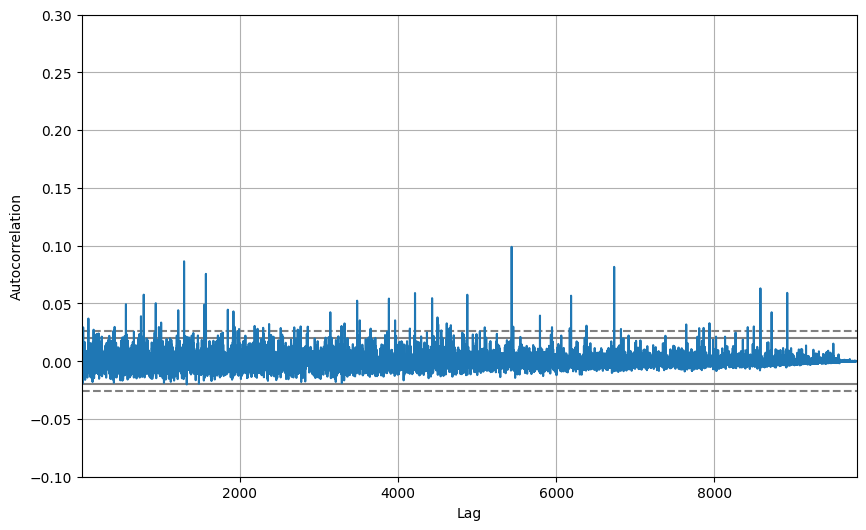

In [35]:
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(df['Sales'])

plt.ylim(-0.1, 0.3)

In [36]:
model = ARIMA(data['Sales'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 9800
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -77755.786
Date:                Tue, 18 Jun 2024   AIC                         155523.573
Time:                        23:01:08   BIC                         155566.713
Sample:                             0   HQIC                        155538.190
                               - 9800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8380      0.003   -248.955      0.000      -0.845      -0.831
ar.L2         -0.6696      0.004   -154.784      0.000      -0.678      -0.661
ar.L3         -0.5046      0.005   -109.535      0.0

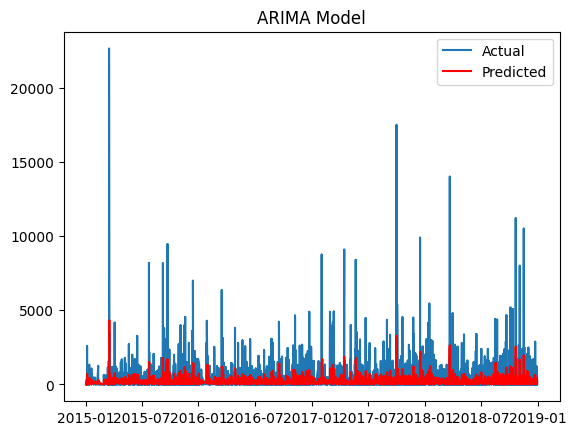

In [39]:

plt.figure()
plt.plot(df['Sales'], label='Actual')
plt.plot(model_fit.fittedvalues, color='red', label='Predicted')


plt.title('ARIMA Model')
plt.legend()

In [45]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(legend=False, title='Residuals')

residuals.plot(kind='kde', title='Density')
residuals.plot(kind='bar')
print(f"Residuals mean: {residuals.mean()}")
print(f"Residuals stdev: {residuals.std()}")